
# **EMOTIONAL SPEECH RECOGNITION ANALYSIS**

## English
El siguiente analisis presenta una clasificacion emocional del discurso, reconociendo 7 emociones (enfado, sorpresa, asco, miedo, felicidad, tristeza y neutral) para el idioma **ingles**.

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [101]:
# IMPORT LIBRARIES
# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Files
import os

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



In [102]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## **1. CARGA DE DATOS**
Para este analisis utilizare el dataset de [RAVDESS](https://zenodo.org/record/1188976.) (Ryerson Audio-Visual Database of Emotional Speech and Song), el cual contiene 7356 archivos (24.8 GB) entre los cuales podemos encontrar 3 modalidades: **solo audio** (en 16 bit, 48 kHz y en formato .wav), **audio-video** (720p H.264, AAC 48kHz, .mp4) y **solo video** sin sonido. Esta base de datos contiene 24 actores profesionales vocalizando dos frases en acento norte americano (_Kids are talking by the door_ y _Dogs are sitting by the door_).</br>


Cada uno de estos archivos estan nombrados de manera unica mediante 7 numeros a modo de descripcion de las caracteristicas del audio. Respeta la siguiente convencion:
- Modalidad (01 Audio y video, 2 Solo video, 3 Solo audio)
- Canal vocal (01 discurso normal, 02 cancion)
- Emocion que representa
- Intensidad Emocional _Si es normal o fuerte. Notese que la voz neutral no contempla la intensidad fuerte_
- Repeticion (si es la primera repeticion _01_ o la segunda _02_)
- Actor que ejecuta la accion



Asi por ejemplo, el archivo **03-01-03-01-01-01-01.wav** dira que es un archivo de solo audio, donde no se vocaliza una frase de manera hablada y con tono alegre. La intensidad es normal, corresponde a la primera repeticion y el actor que la ejecuta es el n. 1


El articulo [(RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391)
 expone un estudio mas en profundidad de este dataset.





In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'RAVDESS']
Size of the dataset: 1440 

happy       192
angry       192
disgust     192
calm        192
sad         192
fear        192
surprise    192
neutral      96
Name: emotion, dtype: int64


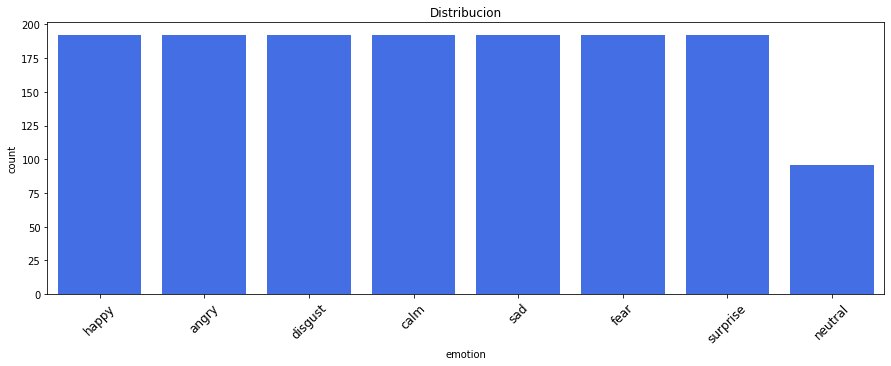

In [104]:
# Imprimimos la distribucion de las clases

df_aux = pd.DataFrame()
df_aux['emotion'] = list(class_distribution.keys())
df_aux['count']  = list(class_distribution)
fig, axs = plt.subplots(figsize=(15, 5))
axs = sns.barplot(x = 'emotion', y = 'count', color = '#2962FF', data = df_aux)
axs.set_title('Distribucion')
axs.set_xticklabels(axs.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [65]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
332,angry,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
212,sad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1347,angry,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1432,surprise,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
276,disgust,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1242,fear,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
741,happy,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
595,surprise,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
352,surprise,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
179,surprise,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...


# **2. EXPLORACION DE LOS DATOS**

### **2.1 EXPOSICION DE UNA MUESTRA ALEATORIA**



In [66]:

def plot_audio_waveform(audio_sample):
  '''
  Muestra la forma de la onda sonora a partir de una muestra.

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio 
  
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  '''
  Muestra el espectograma a partir de una muestra de audio

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
  '''
  Muestra el especograma de una muestra de audio en una ventana de tiempo
  
  Arguments
  ---------
  audio: np.ndarray
    Muestra de audio
  sample_rate: int, optional
    Frecuencia de muestreo de la muestra de audio
  window_size: int, optional

  step_size: int, optional
  
  eps: int, optional
  '''
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/Actor_01/03-01-06-02-01-01-01.wav
110361


Text(0, 0.5, 'Hz')

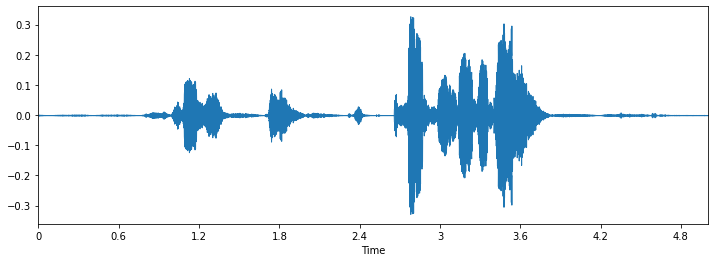

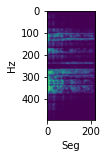

In [67]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Dibuja la grafica de la onda sonora
plot_audio_waveform(random_sample)

# Dibuja el espectograma
freqs, times, spectrogram = log_specgram(random_sample)

# Muestra la firgura
plt.figure(figsize=(30, 2))
plt.imshow(spectrogram)
plt.xlabel('Seg')
plt.ylabel('Hz')

In [68]:

# samplingFrequency, signalData = wavfile.read(random_sample)
# plt.plot(sample)
# plt.specgram(sample, Fs=sampling_rate)

### **2.2 COMPARATIVA DE TODAS LAS EMOCIONES**
Ahora que hemos conseguido extraer la grafica de una determinada muestra de sonido, vamos a comparar la graficas correspondientes a las muestras de sonido de distintas emociones respectivamente. Para ello vamos a distinguir por genero, ya que podria suponer una diferencia.

In [69]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  
  Arguments
  --------- 
    gender: str
      Genero del actor en el audio
    rows:  int, optional
      Filas en las que se muestra. 5 por defecto
    cols: int, optional
      Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


### 2.2.1 COMPARATIVA DE EMOCIONES PARA HOMBRE
En primer lugar vemos que aspecto tienen las emociones para la **voz masculina**

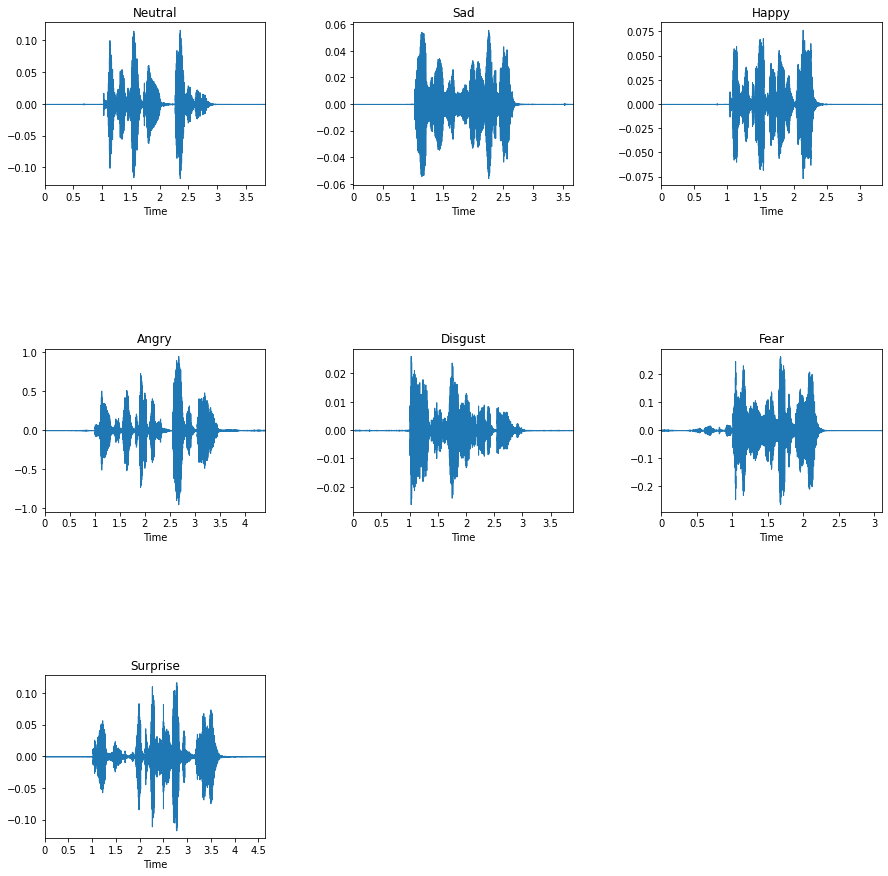

In [70]:
plot_all_emotion_waveforms('male')


### 2.2.2 COMPARATIVA DE EMOCIONES DE MUJER
Vemos el aspecto que tienen las emociones para la **voz femenina**


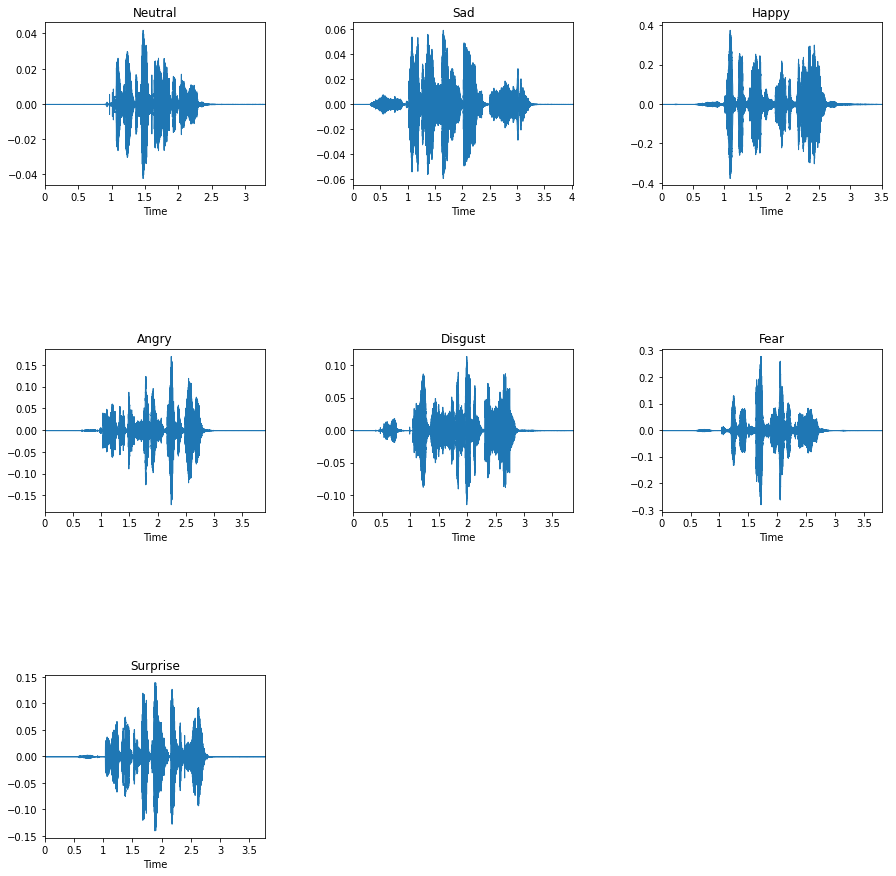

In [71]:
plot_all_emotion_waveforms('female')

Se puede observar en los resultados, que la se;al asociada a cada una de las emociones presenta diferencias con respecto a la voz femenina y la masculina. A simple vista no podemos hablar de unos cambios constantes en determinados puntos. Vemos que la *felicidad* masculina y femennina es expresada de una manera similar, al contrario, por ejemplo, de lo que ocurre con el *miedo*, donde en su version masculina presenta mas saltos entre sus picos de frecuencia. por lo que es algo que deberemos tener en cuenta en este analisis

# **3. EXTRACCION DE CARACTERISTICAS**

### **3.1 EXTRACCION DE CARACTERISTICAS CON MFCC**

In [72]:
def get_features(df):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa

  Aguments
  ---------
    df : dataframe
    Dataframe que contiene el path donde se encuentra la pista de audio

  Return
  -------
   data: np.array 
   Caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = get_features_single_file(df.path[index])
    data.loc[index] = [data_features]

  return data


def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  data_features = np.mean(mfcc, axis = 0)

  return data_features



def get_random_emotion(df, emotion):
  '''
  Devuelve el path de un archivo de audio aleatorio a partir de un dataframe.

  Aguments
  ---------
  df: dataframe
    Caracteristicas de la muestra de audio organizadas por emociones
  emotion: str
    Nombre de la emocion 
    
  Return
  -------
  '''
  if 'emotion' not in df:
    return -1

  aux_df = df[df['emotion'] == emotion]
  item = random.choice(aux_df.index.to_list())
  path = aux_df.path[item]

  return path

def plot_waves_comparative(df1, df2, df1_title = 'Wave 1', df2_title = 'Wave 2', title_ = 'Title'):
  '''
  Imprime la grafica de dos waveforms a partir de sus caracteristicas.

  Aguments
  ---------
  df1: dataframe
    Caracteristicas de la primera muestra de audio
  df2: dataframe
    Caracteristicas de la segunda muestra de audio
  df1_title: str, optional
    Titulo para la primera grafica
  df2_title: str, optional
    Titulo para la segunda grafica 
  title_: str, optional
    Titulo para la figura

  '''
  plt.figure(figsize=(20, 15))
  plt.subplot(3,1,1)
  plt.title(title_)
  plt.plot(df1, label= df1_title)
  plt.plot(df2, label= df2_title)
  plt.legend()


def plot_all_comparative_waveforms(rows = 3, cols = 3):
  '''


  Aguments
  ---------
  Return
  -------
  '''

  labels = list(EnglishSpeech_df['emotion'].unique())
  features_dict = dict()
  for label in labels:
    # Female
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], label)
    # female_feat = get_features_single_file(path)
    key = 'female_' + label
    features_dict[key] = get_features_single_file(path)
    # Male
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], label)
    # male_feat = get_features_single_file(path)
    key = 'male_' + label
    features_dict[key] = get_features_single_file(path)

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i, label in enumerate(labels):
    key = 'female_' + label
    df_fem = features_dict[key]
    key = 'male_' + label
    df_mal = features_dict[key]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.plot(df_fem, label= 'female')
    plt.plot(df_mal, label= 'male')
    plt.legend()



In [73]:
# Guardamos las caracteristicas a partir de la estructura que hemos construido antes
features_data = get_features(EnglishSpeech_df)
print(features_data)

100%|██████████| 1440/1440 [05:21<00:00,  4.48it/s]

                                                   data
0     [-66.059105, -66.059105, -66.059105, -66.05910...
1     [-73.84225, -73.84225, -73.84225, -73.72053, -...
2     [-61.85075, -62.89586, -63.831463, -60.553463,...
3     [-70.26854, -70.26854, -70.26854, -70.26854, -...
4     [-69.05201, -69.05201, -69.05201, -69.05201, -...
...                                                 ...
1435  [-59.850037, -59.850037, -59.850037, -59.85003...
1436  [-58.232124, -58.232124, -58.232124, -58.23212...
1437  [-56.9414, -56.9414, -56.9414, -56.9414, -56.9...
1438  [-48.669613, -45.722324, -46.04846, -46.527206...
1439  [-55.255962, -55.255962, -55.187458, -55.34609...

[1440 rows x 1 columns]


In [74]:
# features_data.head()
f_df = pd.DataFrame(features_data['data'].values.tolist())
f_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-65.682808,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-65.751534,-63.380966,-62.700752,-65.098381,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.059105,-66.002815,-61.924988,-59.585251,-56.340050,-54.956478,-55.591431,...,-55.764549,-58.545471,-55.988743,-56.975449,-61.780460,-65.383774,-63.935688,-63.328606,-62.011509,-61.251255,-62.367161,-62.563297,-61.352036,-63.539749,-64.852814,-61.058853,-60.734673,-62.970982,-65.925476,-66.059105,-66.059105,-65.233574,-64.616928,-65.550819,-66.059105,-66.059105,-65.296371,-61.711594,-60.360741,-60.373734,-57.540462,-55.827206,-57.742855,-59.797207,-60.976192,-62.663845,-64.574211,-63.783470,-61.517021,-58.217075
1,-73.842247,-73.842247,-73.842247,-73.720528,-73.842247,-73.842247,-73.842247,-73.304657,-72.807800,-73.842247,-73.842247,-73.318672,-65.748177,-64.292671,-63.901077,-62.007446,-61.668205,-60.353573,-62.795673,-71.039787,-67.588890,-70.090088,-71.926071,-72.205902,-73.842247,-71.767052,-69.865593,-65.621536,-62.510490,-60.178303,-61.991924,-64.299286,-65.288956,-67.775200,-66.402573,-64.903633,-62.787174,-58.825623,-54.061951,-53.111855,...,-30.143034,-30.706505,-30.394371,-29.729404,-30.308889,-29.539310,-30.008671,-29.881319,-30.892702,-33.100491,-30.836924,-30.755800,-30.185331,-31.663187,-33.846001,-34.118858,-36.499855,-38.370602,-39.913235,-41.742886,-42.856297,-43.770603,-44.719074,-45.199142,-46.888340,-48.836185,-49.847420,-49.986946,-49.796787,-51.918861,-51.597122,-50.530499,-53.475498,-54.207867,-51.526096,-52.561081,-54.772148,-56.335018,-57.500893,-56.567909
2,-61.850750,-62.895859,-63.831463,-60.553463,-60.822613,-62.074265,-64.890053,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-63.680496,-59.563381,-59.069218,-62.143883,-62.432308,-64.842644,-65.390717,-65.390717,-63.870674,-61.361370,-59.707901,-59.798950,-62.271980,-60.550758,-58.221989,-58.359535,-60.649246,-53.255680,-51.225761,-49.681644,-51.877785,-56.027061,-57.659988,-58.432919,-58.608315,-60.930626,-64.419708,-58.210060,...,-53.209366,-54.153305,-52.783730,-53.129257,-57.196308,-55.771366,-55.110691,-57.924313,-56.827610,-57.973213,-56.144112,-53.264206,-55.031013,-58.032761,-62.374447,-63.339924,-59.325741,-58.808514,-62.785091,-63.299229,-63.523270,-64.284760,-64.732941,-61.391403,-60.566311,-61.249634,-64.318771,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717,-65.390717
3,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.001549,-69.981659,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-66.097252,-63.398201,-68.260742,-70.268539,-69.666077,-68.817963,-66.116409,-63.903828,-68.622383,-70.268539,-69.642830,-68.421051,-70.044975,-67.233437,-66.351326,-68.504265,-66.578323,-62.981785,-62.694344,-65.907471,...,-40.011742,-39.581402,-41.080826,-41.835026,-43.329956,-44.811626,-46.607578,-45.475891,-48.727745,-51.779503,-51.438679,-52.644341,-54.618233,-56.557270,-56.229717,-53.642990,-52.772163,-51.569214,-54.047665,-55.942867,-54.383808,-54.098572,-52.374531,-51.011082,-53.335392,-55.216549,-57.184219,-60.705837,-57.998859,-57.543839,-58.802940,-57.448360,-58.897434,-58.751919,-57.406570,-60.079292,-63.427677,-62.639439,-61.083599,-60.235447
4,-69.052010,-69.052010,-69.052010,-69.052010,-69.052010,-68.755501,-69.052010,-69.052010,-69.052010,-68.359833,-68.879417,-69.052010,-68.494072,-67.110680,-66.995140,-68.018822,-66

In [75]:
features_complete_df = pd.concat((f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
features_complete_df = features_complete_df.fillna(0)

# Barajamos las filas para imrpimir una muestra 
random_aux = shuffle(features_complete_df)
random_aux.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,gender,emotion
1398,-52.389118,-52.389118,-52.389118,-52.389118,-54.024338,-54.198811,-53.286297,-52.389118,-52.389118,-52.400047,-52.469028,-52.696060,-52.787930,-52.718849,-52.189495,-52.233463,-52.145565,-52.183815,-51.373539,-51.253620,-51.338783,-50.755802,-51.299252,-51.221092,-49.483212,-49.381592,-50.113770,-49.560287,-49.700581,-47.585342,-44.165962,-43.339363,-43.518436,-42.432697,-38.720211,-40.837837,-46.843666,-47.909977,-46.552193,-44.933304,...,-40.970211,-41.685188,-42.433212,-38.285568,-36.979221,-37.181259,-36.304649,-35.868050,-34.421837,-32.829403,-32.987595,-34.318954,-34.167858,-33.319733,-32.640007,-32.952801,-32.358231,-30.912935,-31.092449,-29.834394,-32.618061,-35.645199,-37.929939,-38.950829,-41.232021,-41.285690,-41.295193,-42.536621,-44.454281,-44.524899,-46.363464,-46.383846,-47.493130,-51.349522,-51.253216,-50.509914,-49.606838,-47.600204,female,happy
432,-56.585930,-56.565365,-58.082439,-57.198521,-58.287361,-55.153824,-54.376526,-53.642910,-52.773846,-54.718315,-52.022285,-52.112652,-54.087650,-54.369999,-54.904961,-54.046043,-52.282314,-52.494473,-53.973980,-55.365940,-52.319893,-50.646301,-49.419945,-52.127083,-53.338406,-52.504311,-54.312607,-50.506451,-48.966732,-54.973392,-54.384426,-52.535599,-53.577312,-54.376553,-54.697075,-54.202515,-55.876953,-55.963772,-53.363319,-51.325970,...,-40.856709,-43.123264,-40.413460,-41.371773,-43.914322,-46.673378,-47.563267,-47.866848,-47.117455,-46.546291,-50.099796,-48.466702,-47.254723,-48.518684,-49.812157,-48.995415,-49.436398,-51.169155,-51.566444,-53.975731,-54.776043,-53.471012,-53.874954,-50.527237,-49.854305,-50.890869,-52.181587,-55.062073,-53.669876,-53.753269,-54.539631,-54.457912,-51.937462,-53.099045,-53.586876,-50.854580,-50.651638,-51.128147,female,happy
372,-51.124260,-51.819599,-51.942451,-52.817574,-54.652920,-56.915993,-57.324516,-56.917503,-54.596577,-54.187859,-53.546860,-53.238163,-54.171574,-56.988705,-59.465897,-60.745945,-60.656471,-56.124386,-53.779404,-52.747272,-52.498116,-53.687248,-56.348099,-57.878059,-57.030247,-57.313931,-58.653343,-60.029537,-58.522476,-58.075619,-61.224186,-63.964851,-64.218803,-64.218803,-64.224220,-64.223160,-60.520523,-55.820393,-53.366634,-49.796379,...,-39.135166,-40.904289,-40.700142,-42.212112,-45.103569,-46.983555,-46.148155,-45.712788,-45.665855,-44.649452,-45.156792,-46.187519,-45.536026,-43.703201,-42.823933,-43.397644,-43.494606,-44.292496,-44.603470,-45.003052,-46.641315,-47.947327,-48.491356,-46.906700,-47.896118,-48.377609,-47.455185,-46.967205,-48.272942,-50.800171,-50.776508,-51.097744,-51.171696,-50.122532,-49.048725,-49.426735,-50.383286,-53.369747,male,happy
348,-57.264530,-57.264530,-56.639900,-56.888126,-57.264530,-57.264530,-57.264530,-57.264530,-57.264530,-56.852196,-56.516014,-56.750263,-56.890842,-56.106674,-54.544209,-52.299988,-52.595455,-54.333130,-54.276859,-53.015160,-52.820499,-53.228622,-53.061394,-53.078697,-52.465355,-52.658340,-52.714535,-53.601395,-54.511986,-54.211563,-53.156471,-51.878521,-50.297016,-49.307411,-49.016964,-48.437138,-49.325237,-49.662399,-49.042545,-51.191307,...,-50.473770,-51.668602,-52.506863,-51.699871,-52.487961,-53.432693,-52.639736,-52.974113,-52.823296,-53.126080,-53.225063,-53.751907,-55.488609,-54.475727,-54.114021,-53.616577,-53.127319,-52.962833,-52.909992,-53.743347,-55.767193,-56.177692,-55.713009,-55.461914,-56.274967,-56.643978,-56.621662,-56.812679,-57.225883,-57.264530,-57.264530,-56.306473,-56.135582,-55.762291,-55.964928,-57.088661,-56.611900,-56.863533,female,surprise
1152,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.213257,-54.2132

### Division del dataframe
Vamos a dividir el dataframe por el genero, para comprobar como afecta este a la prosodia en la voz femenina y masculina por separadas, dadas las mismas emociones en el analisis

In [76]:
male_features_df = features_complete_df[(features_complete_df['gender'] == 'male')]
female_features_df = features_complete_df[(features_complete_df['gender'] == 'female')]

### Comparativa
Ahora que podemos extraer las caracteristicas de las señales, vamos a comparar la misma emocion, (por ejemplo *enfado*) en la voz femenina y la masculina.


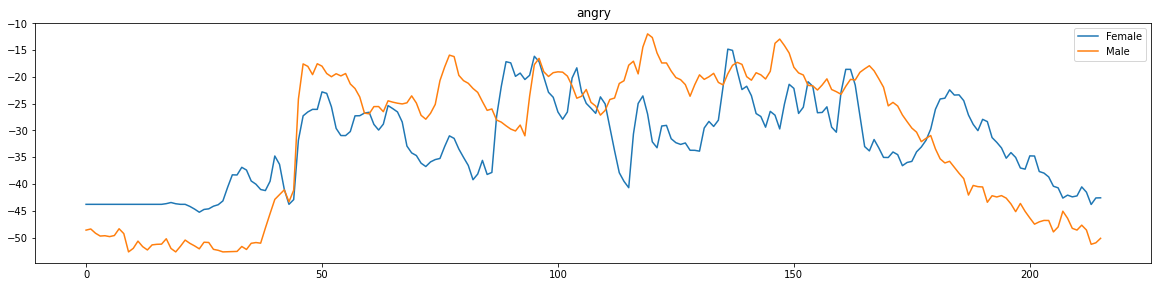

In [77]:
# Extraemos una muestra aleatoria para la emocion: enfado 
# Female
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], 'angry')
female_feat = get_features_single_file(path)
# print(len(female_feat))
# Male
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], 'angry')
male_feat = get_features_single_file(path)
# print(len(male_feat))

plot_waves_comparative(female_feat, male_feat, "Female", "Male", "angry")



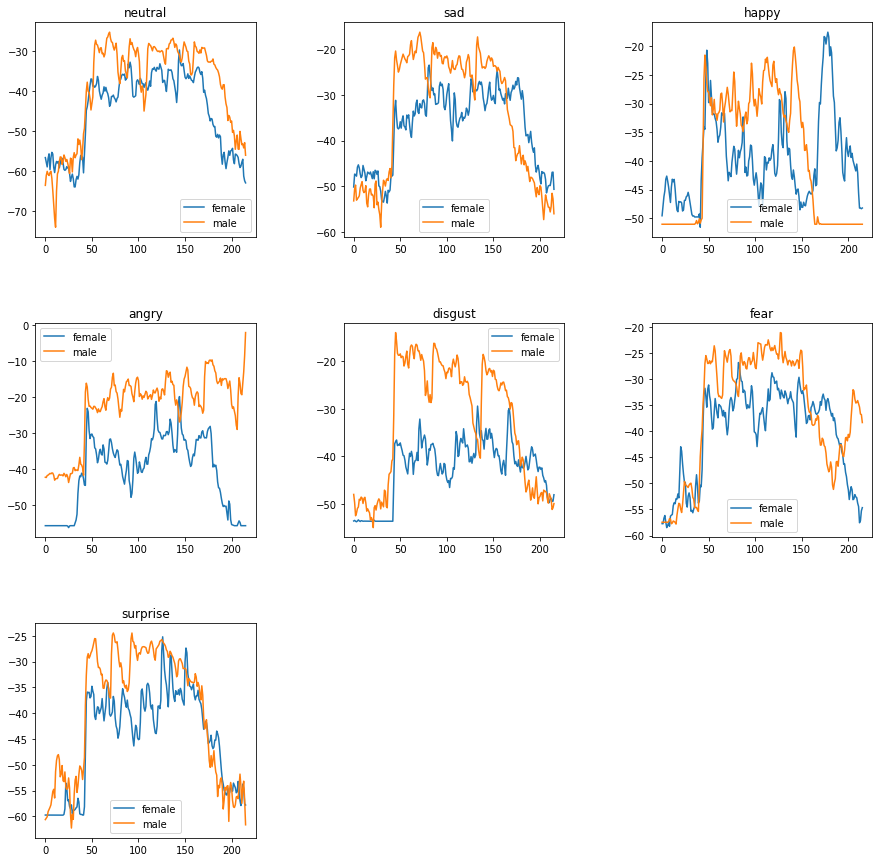

In [78]:
plot_all_comparative_waveforms()

### **3.2 PREPARACION DE LOS DATOS**


In [79]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test
  # return train_test_split(X, Y, stratify = Y, test_size=0.25)#X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  Aguments
  ---------
  Return
  -------
  '''
  # Now because we are mixing up a few different data sources, it would be wise to normalise the data. 
  # This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, 
  # the problem used to be know as "exploding gradients".
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Lets few preparation steps to get it into the correct format for Keras 
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))

  # # Pickel the lb object for future use 
  # filename = 'labels'
  # outfile = open(filename,'wb')
  # pickle.dump(label_encoder, outfile)
  # outfile.close()

  # print(x_train_norm.shape)
  # print(label_encoder.classes_)

  return x_train_norm, y_train, x_test_norm, y_test, label_encoder



### 3.2.1 DIVISION DE LOS DATOS EN ENTRENAMIENTO Y TEST

In [80]:
# NOTA: Aqui estoy comprobando los datos que me da si divido entrenamiento y test con split de toda la vida

# # female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df)
# female_X_train.head()
# print(918 in female_X_train.index)

In [81]:
X_train, X_test, Y_train, Y_test = split_training_test(features_complete_df)
X_train.head()
print(X_train.shape)

(1080, 216)


In [82]:
# Comprobamos la distribución de las clases (emociones en nuestro caso)
Y_train.value_counts()

neutral     216
sad         144
happy       144
fear        144
surprise    144
angry       144
disgust     144
Name: emotion, dtype: int64

In [83]:
# Comprobamos que no hay valores NaN
X_train.isna().sum().sum()

0

### 3.2.2 NORMALIZACION DE LOS DATOS


In [84]:
X_train_norm, X_test_norm = data_normalization(X_train, X_test)
print(features_complete_df.shape)

# Comprobamos imprimiendo una muestra de los datos
indx = random.randint(0, len(features_complete_df))
X_train[indx:indx+10]

(1440, 218)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215


### 3.2.3 CATEGORIZACION DE LOS DATOS

In [85]:
X_train, Y_train, X_test, Y_test, labels_whole = data_to_categorical(X_train_norm, Y_train, X_test_norm, Y_test)

In [86]:
print(labels_whole.classes_)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### 3.2.4 CAMBIO DE DIMENSION

In [87]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape)

(1080, 216, 1)


Comprobamos que despues de los cambios hay unas dimensiones coherentes

In [88]:
print("X Train: {} --> Y Train: {}".format(X_train.shape, Y_train.shape))
print("\nX Test: {} --> Y Test: {}".format(X_test.shape, Y_test.shape))

X Train: (1080, 216, 1) --> Y Train: (1080, 7)

X Test: (360, 216, 1) --> Y Test: (360, 7)


### **3.3 PREPARACION DE LOS DATOS PARA _Female_**

In [89]:
# 1. Division de los datos: Entrenamiento y Test
female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df) # with StratifiedShuffleSplit

# 2. Normalizacion
x_train_female_norm, x_test_female_norm = data_normalization(female_X_train, female_X_test)
print(x_train_female_norm.shape)

# 3. Categorización
female_X_train, female_Y_train, female_X_test, female_Y_test, labels_female = data_to_categorical(x_train_female_norm, female_Y_train, x_test_female_norm, female_Y_test)
print(labels_female.classes_)

# 4. Cambio de Dimensión
X_train_female = np.expand_dims(female_X_train, axis=2)
X_test_female = np.expand_dims(female_X_test, axis=2)

print("\nTrain size: {}\nTest size:{}".format(X_train_female.shape, X_test_female.shape))
print("\nTrain size: {}\nTest size:{}".format(female_Y_train.shape, female_Y_test.shape))

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Train size: (540, 216, 1)
Test size:(180, 216, 1)

Train size: (540, 7)
Test size:(180, 7)


### **3.4 PREPARACION DE LOS DATOS PARA _Male_**


In [90]:
# 1. Division de los datos: Entrenamiento y Test
male_X_train, male_X_test, male_Y_train, male_Y_test =split_training_test(male_features_df)
male_X_train.head()

# 2. Normalizacion
x_train_male_norm, x_test_male_norm = data_normalization(male_X_train, male_X_test)
print(x_train_male_norm.shape)

# 3. Categorización
male_X_train, male_X_test, male_Y_train, male_Y_test, labels_male = data_to_categorical(x_train_male_norm, male_Y_train, x_test_male_norm, male_Y_test)
print(labels_male.classes_)

# 4. Cambio de Dimensión
X_train_male = np.expand_dims(X_train, axis=2)
X_test_male = np.expand_dims(X_test, axis=2)

print("\nTrain size: {}\nTest size:{}".format(X_train_female.shape, X_test_female.shape))

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Train size: (540, 216, 1)
Test size:(180, 216, 1)


# **4. EL MODELO**
## 4.1 Diseño del modelo

In [91]:
def model_cnn(x_train, n_classes):
  '''

  Aguments
  ---------
  Return
  -------
  '''
  print("Model for {} classes\n".format(n_classes));

  model = Sequential()
  # 1 Capa
  model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  
  model.add(Activation('relu'))
  # 2 Capa
  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))
  # 3 Capa
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # # 4 Capa
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # # 5 Capa
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # 6 Capa
  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))
  # 6 Capa
  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))
  # 7 Capa
  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  # 8 Capa
  model.add(Flatten())
  model.add(Dense(n_classes)) # Target class number
  model.add(Activation('softmax'))

  return model



## Compilación del modelo

In [92]:
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# X_train_female , X_test_female
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()


Model for 7 classes

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (Non

In [93]:
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 15)

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_female, female_Y_test),
                        callbacks=[rlrp])

Epoch 1/100
34/34 [==============================] - 12s 317ms/step - loss: 1.9665 - accuracy: 0.2104 - val_loss: 1.9474 - val_accuracy: 0.1611
Epoch 2/100
34/34 [==============================] - 10s 306ms/step - loss: 1.9373 - accuracy: 0.1978 - val_loss: 1.9523 - val_accuracy: 0.1333
Epoch 3/100
34/34 [==============================] - 10s 306ms/step - loss: 1.8873 - accuracy: 0.2462 - val_loss: 1.9555 - val_accuracy: 0.1333
Epoch 4/100
34/34 [==============================] - 11s 313ms/step - loss: 1.8899 - accuracy: 0.2522 - val_loss: 1.9576 - val_accuracy: 0.1333
Epoch 5/100
34/34 [==============================] - 11s 311ms/step - loss: 1.8452 - accuracy: 0.2782 - val_loss: 1.9585 - val_accuracy: 0.1333
Epoch 6/100
34/34 [==============================] - 11s 311ms/step - loss: 1.8289 - accuracy: 0.3319 - val_loss: 1.9582 - val_accuracy: 0.1333
Epoch 7/100
34/34 [==============================] - 10s 306ms/step - loss: 1.8211 - accuracy: 0.2953 - val_loss: 1.9569 - val_accuracy:

### Persistencia del modelo
Guardamos el modelo para un uso posterior sin necesidad de volverlo a entrenar


In [94]:
# detectar que modelo acaba de ejecutarse para guardarlo automaticamente?
model.save('model_english_female_SER.h5')

## Validación del modelo

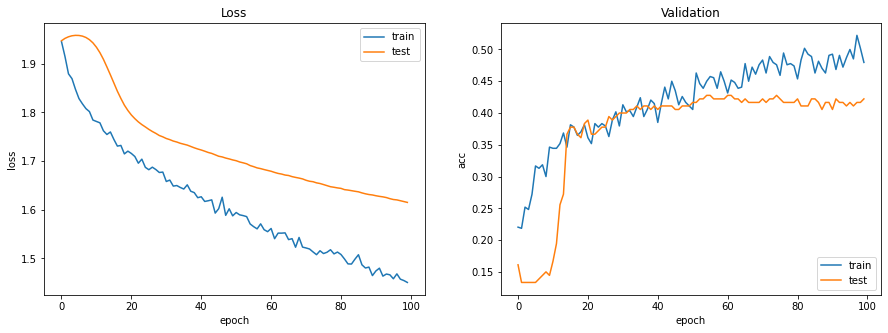

In [95]:

# Mostramos la grafica loss 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'test'], loc='upper right')

# Mostramos la grafica accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Validation')
ax2.set(xlabel='epoch', ylabel='acc')

ax2.legend(['train', 'test'], loc='lower right')


In [96]:
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

2/2 [==============================] - 1s 212ms/step - loss: 1.6152 - accuracy: 0.4222
Loss: 1.6151858568191528 
Accuracy: 42.222222685813904%


## Predicción

In [97]:
# Predecimos los valores a partir de los datos de test
y_pred = model.predict(X_test_female)
y_pred_class = np.argmax(y_pred, axis = 1)
y_true = np.argmax(female_Y_test, axis = 1)

In [98]:
# labels_female
y_pred_class.astype(int).flatten()

array([4, 5, 1, 4, 1, 4, 2, 4, 3, 4, 2, 0, 5, 1, 1, 6, 2, 0, 6, 0, 4, 6,
       4, 4, 4, 6, 6, 6, 4, 4, 4, 3, 0, 0, 4, 3, 4, 1, 0, 6, 4, 4, 0, 4,
       5, 3, 3, 2, 6, 4, 0, 3, 4, 2, 2, 4, 4, 6, 0, 4, 4, 6, 1, 6, 2, 6,
       4, 2, 1, 0, 3, 5, 0, 4, 4, 2, 4, 0, 6, 4, 6, 4, 4, 2, 4, 0, 4, 1,
       0, 5, 4, 3, 0, 6, 2, 2, 4, 4, 4, 0, 1, 5, 0, 3, 0, 4, 6, 3, 6, 4,
       4, 5, 5, 4, 5, 4, 4, 6, 6, 4, 6, 6, 4, 0, 0, 4, 3, 4, 6, 0, 3, 2,
       4, 6, 6, 6, 0, 5, 4, 0, 6, 4, 1, 1, 4, 0, 1, 5, 6, 6, 1, 5, 0, 1,
       0, 6, 6, 0, 4, 4, 6, 5, 1, 4, 1, 6, 0, 6, 4, 2, 6, 0, 1, 4, 6, 2,
       3, 3, 4, 4])

In [99]:
y_true

array([1, 0, 0, 4, 0, 4, 6, 5, 0, 4, 3, 2, 1, 0, 1, 2, 2, 1, 6, 1, 4, 6,
       4, 4, 4, 2, 6, 1, 3, 3, 4, 3, 0, 0, 4, 3, 4, 2, 0, 5, 4, 4, 0, 5,
       2, 2, 3, 3, 6, 4, 0, 6, 4, 2, 2, 4, 5, 5, 3, 1, 4, 3, 1, 0, 3, 3,
       6, 0, 1, 3, 4, 4, 4, 4, 4, 5, 1, 2, 5, 5, 6, 5, 4, 2, 4, 0, 5, 6,
       6, 5, 5, 5, 3, 2, 2, 2, 5, 4, 5, 0, 3, 6, 0, 2, 3, 5, 0, 3, 1, 5,
       5, 1, 4, 4, 6, 1, 5, 6, 6, 1, 3, 3, 2, 2, 5, 4, 1, 4, 3, 3, 6, 0,
       4, 1, 2, 6, 5, 1, 2, 6, 2, 4, 6, 3, 0, 0, 1, 2, 6, 6, 1, 3, 0, 1,
       2, 3, 0, 0, 1, 4, 6, 5, 1, 4, 1, 1, 0, 2, 4, 3, 6, 6, 0, 5, 6, 5,
       4, 2, 4, 4])

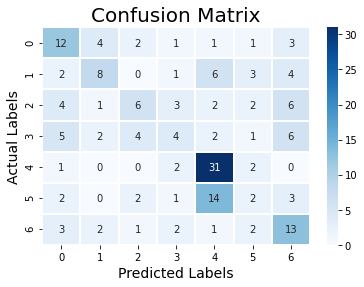

In [100]:
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()